# **Data preparation**

In [2]:
DATA_SOURCE = "../../01_data/adult_reconstruction.csv"
FILE_TO_SAVE = "../../01_data/prepared_data.csv"

In [3]:
import pandas as pd
import numpy as np

import preprocessing_utils

1 Physical GPUs, 1 Logical GPUs


2022-11-19 22:21:34.668115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-19 22:21:35.304702: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1621 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 860M, pci bus id: 0000:01:00.0, compute capability: 5.0


In [4]:
census_data = pd.read_csv(DATA_SOURCE)

## Overview

In [5]:
census_data.head()

,hours-per-week,age,capital-gain,capital-loss,workclass,education,education-num,marital-status,relationship,race,gender,native-country,income,occupation
0,20,40,0,0,Private,Bachelors,13,Married-civ-spouse,Wife,White,Female,United-States,49100,Tech-support
1,40,21,0,0,Private,Some-college,10,Divorced,Own-child,White,Male,United-States,11500,Craft-repair
2,10,17,0,0,Private,11th,7,Never-married,Own-child,White,Male,United-States,2600,Other-service
3,50,51,0,0,Private,HS-grad,9,Married-civ-spouse,Husband,Asian-Pac-Islander,Male,Cambodia,38997,Sales
4,38,28,0,0,Private,Bachelors,13,Never-married,Not-in-family,White,Male,?,41400,Exec-managerial


<AxesSubplot:>

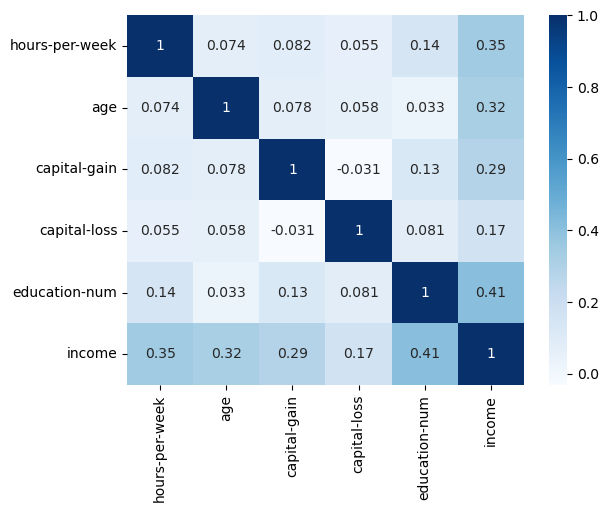

In [6]:
import seaborn as sb
corr = census_data.corr()
sb.heatmap(corr, cmap="Blues", annot=True)

<AxesSubplot:>

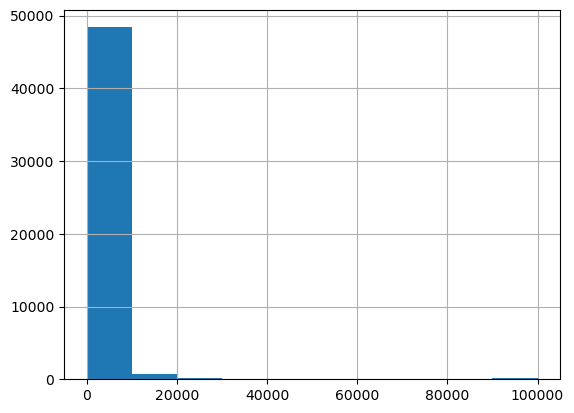

In [7]:
census_data["capital-gain"].hist()

## Dropping (label) outliers

We will drop those records, which are considered to be outliers (i.e. income>95%)

In [8]:
census_data["income"] = (census_data["income"]).astype(int)

Text(0.5, 1.0, 'Histogram of incomes\n(with outliers)')

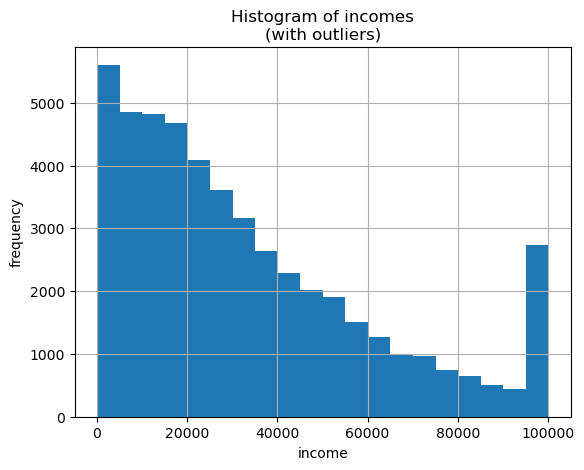

In [9]:
import matplotlib.pyplot as plt
census_data["income"].hist(bins=20)
plt.xlabel("income")
plt.ylabel("frequency")
plt.title("Histogram of incomes\n(with outliers)")

In [10]:
census_data = census_data[census_data["income"] <= census_data["income"].quantile(.95)]

Text(0.5, 1.0, 'Histogram of incomes\n(withot outliers)')

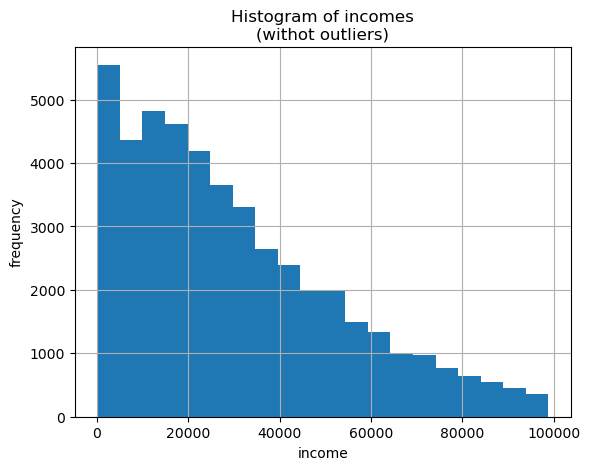

In [11]:
import matplotlib.pyplot as plt
census_data["income"].hist(bins=20)
plt.xlabel("income")
plt.ylabel("frequency")
plt.title("Histogram of incomes\n(withot outliers)")

In [12]:
census_data = census_data[census_data["workclass"] != "?"]

## Partitioning data

In [13]:
categorical = ["workclass",
               "marital-status",
               "relationship",
               "race",
               "native-country",
               "occupation"]
numeric_mean_std = ["hours-per-week", "age",]
numeric_max = ["capital-gain", "capital-loss", "education-num"]

In [16]:
indices = []
indices.append(census_data["education-num"] < 10) #under educated
indices.append(census_data["education-num"] >= 13) #well educated
indices.append(np.logical_and(census_data["education-num"]>=10, census_data["education-num"]<13)) #college educated

prepared_X = preprocessing_utils.categorical_encoding_and_scaling(census_data, categorical, numeric_mean_std, numeric_max)
prepared_X = np.hstack([prepared_X, np.array(census_data["gender"]=="Male").astype(int).reshape([len(prepared_X), 1])])
prepared_y = np.array(census_data["income"]/max(census_data["income"])).reshape([len(prepared_X), 1])

(44243,)
(44243, 2)
(44243,)
(44243, 3)
(44243,)
(44243, 4)


## Train/Test splitting

In [17]:
TEST_PORTION = .1
TRAIN_PATH = "../../01_data/train/"
TEST_PATH = "../../01_data/test/"

In [18]:
names = ["under_educated", "well_educated", "college_educated"]

In [21]:
for i,name in enumerate(names):
    limit = int(TEST_PORTION*np.sum(indices[i]))
    np.savetxt(TEST_PATH+name+"_features.csv", prepared_X[indices[i]][:limit], delimiter=",")
    np.savetxt(TRAIN_PATH+name+"_features.csv", prepared_X[indices[i]][limit:], delimiter=",")
    np.savetxt(TEST_PATH+name+"_labels.csv", prepared_y[indices[i]][:limit], delimiter=",")
    np.savetxt(TRAIN_PATH+name+"_labels.csv", prepared_y[indices[i]][limit:], delimiter=",")